In [1]:
from cProfile import label
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict
import pickle as pl

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Data Loading with x0 and xT
class ODEDataSet():
      
    def __init__(self):
        
        # loading the csv file from the folder path
        data1 = np.loadtxt('ODE_records.csv', delimiter=',',
                           dtype=np.float32, skiprows=1)
          
        # here the 13th column is class label and rest 
        # are features
        self.x = torch.from_numpy(data1[:, [1]])
        self.y = torch.from_numpy(data1[:, [49]])
        self.n_samples = data1.shape[0] 
      
    # support indexing such that dataset[i] can 
    # be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
dataset = ODEDataSet()
x0 = dataset.x
xt = dataset.y
x_train, x_test, y_train, y_test = train_test_split(x0, xt, test_size=0.1)

In [4]:
# Training Process
def train_model(model, trainloader):
    '''
    Function trains the model and prints out the training log.
    INPUT:
        model - initialized PyTorch model ready for training.
        trainloader - PyTorch dataloader for training data.
    '''
    # setup training
    train_loss_list = []
    val_loss_list = []
    # define loss function
    # criterion = nn.NLLLoss()
    criterion = nn.MSELoss()
    # define learning rate
    learning_rate = 0.03
    # define number of epochs
    epochs = 30
    # initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # run training and print out the loss to make sure that we are actually fitting to the training set
    print('Training the model. Make sure that loss decreases after each epoch.\n')
    test_loss_list = []
    train_loss_list = []
    for e in range(epochs):
        running_loss = 0
        test_loss = 0
        x_list=[]
        for x0, xt in trainloader:
            x0 = x0.view(x0.shape[0], -1)
            log_ps = model(x0)
            loss = criterion(log_ps[9], xt)
            ##save to list
            x_output=torch.stack(log_ps)

            x_list.append(x_output.detach().data.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_loss /= len(x_train)
            train_loss_list.append(running_loss)
            # else:
            # print out the loss to make sure it is decreasing
            print(f"Training loss: {running_loss}")

            # model(x_test)
            # test_loss=0
            with torch.no_grad():
                log_test = model(x_test)
                test_loss_ = criterion(log_test[9], y_test)
                test_loss += test_loss_.item()
                test_loss /= len(x_test)
                test_loss_list.append(test_loss)
                running_loss = test_loss
                # running_loss += test_loss.item()
                print(f"Test loss: {running_loss}")

    # Plot the loss
    pl.dump(x_list,open('./x_list.plk','wb'))
    np.savetxt('x_list.txt', np.hstack(x_list)[:, :, 0])
    x_np=np.hstack(x_list)
    ##x 1
    fig = plt.figure(figsize=(10, 5))
    plt.title("x_1 value in 100 epochs")
    plt.plot(x_np[0,:,:])
    fig.savefig('x_1', dpi=fig.dpi)
    
    fig = plt.figure(figsize=(10, 5))
    plt.title("Training Loss")
    plt.plot(train_loss_list, label="train")
    plt.plot(test_loss_list, label="test")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    fig.savefig('training loss.png', dpi=fig.dpi)

In [5]:
class intweight(nn.Module):
    
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(intweight,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(0.1)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha

        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
    
        return x*self.alpha

In [6]:
class ClassifierODEmodel(nn.Module):
    
    def __init__(self):
        super().__init__()

        # initialize layers fully connected 
        self.fc1 = nn.Linear(1,1)
        self.fc2 = nn.Linear(1,1)
        self.fc3 = nn.Linear(1,1)
        self.fc4 = nn.Linear(1,1)
        self.fc5 = nn.Linear(1,1)
        self.fc6 = nn.Linear(1,1)
        self.fc7 = nn.Linear(1,1)
        self.fc8 = nn.Linear(1,1)
        self.fc9 = nn.Linear(1,1)
        self.fc10 = nn.Linear(1,1)

        self.a1 = intweight(1)
        self.a2 = intweight(1)
        self.a3 = intweight(1)
        self.a4 = intweight(1)
        self.a5 = intweight(1)
        self.a6 = intweight(1)
        self.a7 = intweight(1)
        self.a8 = intweight(1)
        self.a9 = intweight(1)
        self.a10 = intweight(1)

    def forward(self, x):
        # make sure the input tensor is flattened
        # add the different activation function to 
        x = x.view(x.shape[0], -1)

        x1 = x + self.a1(nn.LeakyReLU(0.1)(self.fc1(x)))
        x2 = x1 + self.a2(nn.LeakyReLU(0.1)(self.fc2(x1)))
        x3 = x2 + self.a3(nn.LeakyReLU(0.1)(self.fc3(x2)))
        # print(x)
        x4 = x3 + self.a4(nn.LeakyReLU(0.1)(self.fc4(x3)))
        # print(x)
        x5 = x4 + self.a5(nn.LeakyReLU(0.1)(self.fc5(x4)))
        # print(x)
        x6 = x5 + self.a6(nn.LeakyReLU(0.1)(self.fc6(x5)))
        # print(x)
        x7 = x6 + self.a7(nn.LeakyReLU(0.1)(self.fc7(x6)))
        # print(x)
        x8 = x7 + self.a8(nn.LeakyReLU(0.1)(self.fc8(x7)))
        # print(x)
        x9 = x8 + self.a9(nn.LeakyReLU(0.1)(self.fc9(x8)))
        # print(x)
        x10 = x9 + self.a10(nn.LeakyReLU(0.1)(self.fc10(x9)))
    
        return x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 

Loading ODE dataset.

Training model with ODE stuff.

Training the model. Make sure that loss decreases after each epoch.

Training loss: 69.16130288799157
Test loss: 361.0824951171875
Training loss: 53.221542255530196
Test loss: 344.40234130859375
Training loss: 43.716769443469104
Test loss: 266.2933837890625
Training loss: 48.3035674705934
Test loss: 258.55065185546874
Training loss: 34.93232915642556
Test loss: 203.58626708984374
Training loss: 33.63614913426088
Test loss: 199.77636352539062
Training loss: 26.25705538974719
Test loss: 158.20743408203126
Training loss: 27.364078547445576
Test loss: 154.68824829101564
Training loss: 21.575746686271067
Test loss: 121.04605712890626
Training loss: 18.933181316932938
Test loss: 116.76166137695313
Training loss: 16.485813783795646
Test loss: 89.50775146484375
Training loss: 13.647095412350772
Test loss: 84.72285766601563
Training loss: 12.140198439694522
Test loss: 63.332269287109376
Training loss: 9.347629435678547
Test loss: 58.70660339

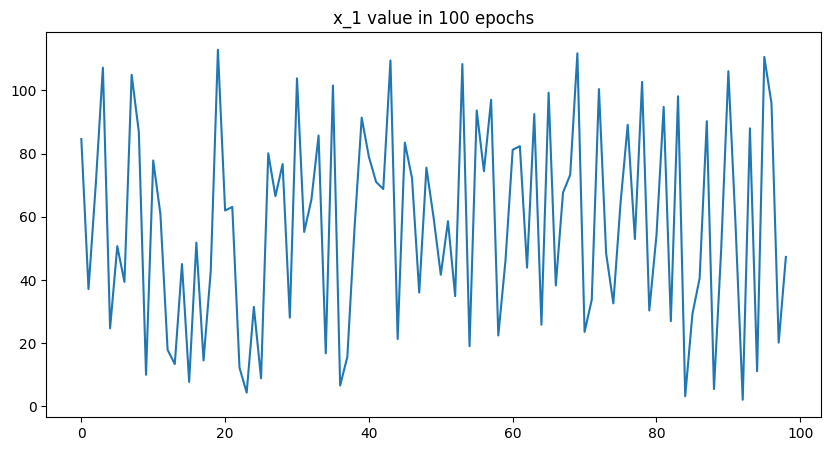

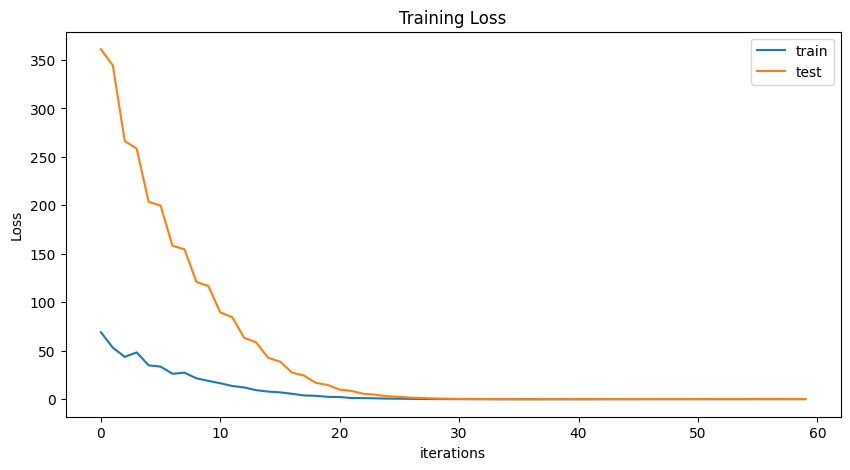

In [7]:
# Define the Mian

def main():
    print('Loading ODE dataset.\n')

    # Define a transform
    # transform = transforms.Compose([torch.tensor()])
    transform = transforms.Compose([transforms.ToTensor()])
    # Download and load the training data for Fashion MNIST
    #dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
    trainset = dataset
    #datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

    # Save the model
    model = ClassifierODEmodel()
    Model_PATH = './ODE_10_model.pt'
    torch.save(ClassifierODEmodel,Model_PATH)
    
    # Save the parameters
    Parmater_PATH = './ODE_10_model.pth'
    
    # Run training
    print('Training model with ODE stuff.\n')
    train_model(model, trainloader)
    
    torch.save(model.state_dict(), Parmater_PATH)

    # load the model and evalute the data

    # model.load_state_dict(torch.load('./ODE_model.pt'))
    # model.eval()

if __name__ == '__main__':
    main()

### Plot Exist Model Parameters

In [8]:
model = ClassifierODEmodel()
Parameter_PATH = './ODE_10_model.pth'
model.load_state_dict(torch.load(Parameter_PATH))
model.eval()

ClassifierODEmodel(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=1, bias=True)
  (fc4): Linear(in_features=1, out_features=1, bias=True)
  (fc5): Linear(in_features=1, out_features=1, bias=True)
  (fc6): Linear(in_features=1, out_features=1, bias=True)
  (fc7): Linear(in_features=1, out_features=1, bias=True)
  (fc8): Linear(in_features=1, out_features=1, bias=True)
  (fc9): Linear(in_features=1, out_features=1, bias=True)
  (fc10): Linear(in_features=1, out_features=1, bias=True)
  (a1): intweight()
  (a2): intweight()
  (a3): intweight()
  (a4): intweight()
  (a5): intweight()
  (a6): intweight()
  (a7): intweight()
  (a8): intweight()
  (a9): intweight()
  (a10): intweight()
)

In [9]:
# Print Named Parameters
for name, para in model.named_parameters():
    print('{}: {}'.format(name, para.norm))

fc1.weight: <bound method Tensor.norm of Parameter containing:
tensor([[0.4598]], requires_grad=True)>
fc1.bias: <bound method Tensor.norm of Parameter containing:
tensor([-0.0041], requires_grad=True)>
fc2.weight: <bound method Tensor.norm of Parameter containing:
tensor([[1.2442]], requires_grad=True)>
fc2.bias: <bound method Tensor.norm of Parameter containing:
tensor([-0.0671], requires_grad=True)>
fc3.weight: <bound method Tensor.norm of Parameter containing:
tensor([[0.6672]], requires_grad=True)>
fc3.bias: <bound method Tensor.norm of Parameter containing:
tensor([1.0429], requires_grad=True)>
fc4.weight: <bound method Tensor.norm of Parameter containing:
tensor([[1.1114]], requires_grad=True)>
fc4.bias: <bound method Tensor.norm of Parameter containing:
tensor([0.6543], requires_grad=True)>
fc5.weight: <bound method Tensor.norm of Parameter containing:
tensor([[-1.1958]], requires_grad=True)>
fc5.bias: <bound method Tensor.norm of Parameter containing:
tensor([-1.5168], require

In [10]:
for name, para in model.named_parameters():
    if name == 'a1.alpha''a2.alpha':
        print('{}: {}'.format(name, para.norm))

In [11]:
import numpy as np
from numpy import genfromtxt
x_true = genfromtxt('ODE_records.csv', delimiter=',')
x = np.loadtxt("x_list.txt")

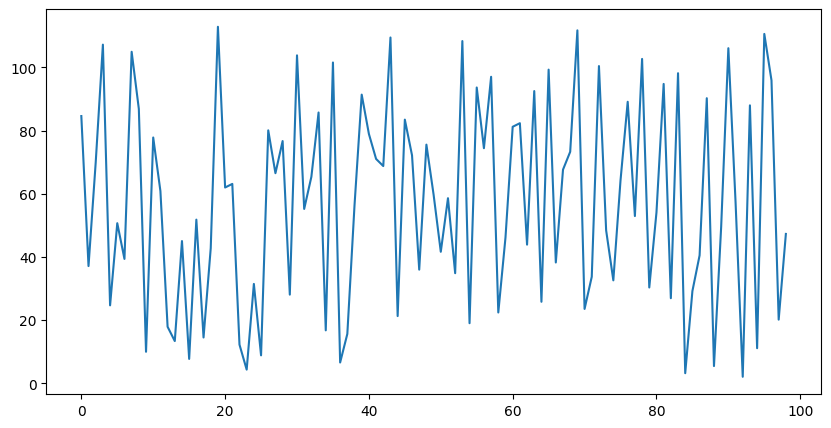

In [12]:
x.shape
fig = plt.figure(figsize=(10, 5))
plt.plot(x[0,:])

### Plot $x_1, x_{10}$ and ground truth

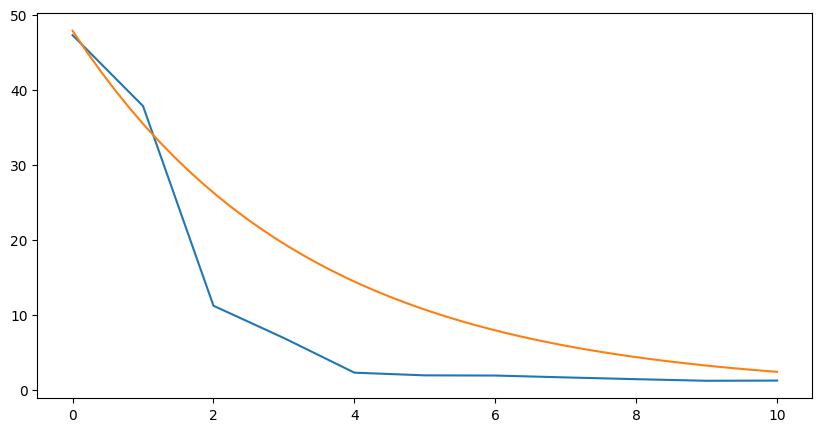

In [19]:
fig = plt.figure(figsize=(10, 5))
plt.plot(x[:,98])
t = np.linspace(0,10)
plt.plot(t,x_true[39,:])